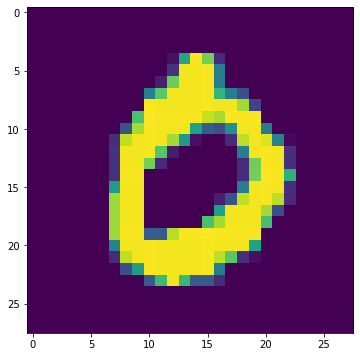

In [33]:
import numpy as np
import cvxpy as cp
from numpy.lib import utils
import torch
import scipy.spatial
import time
from scipy.stats import wishart
from sklearn import metrics

from scipy.sparse.linalg import eigs
from scipy import linalg
import Optimization.MIQP_solver as MIQP_solver
from numpy import linalg as LA
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device("cpu")

Feature_Tr, label_Tr = loadlocal_mnist(
            images_path='MNIST/train-images.idx3-ubyte', 
            labels_path='MNIST/train-labels.idx1-ubyte')
Feature_Te, label_Te = loadlocal_mnist(
            images_path='MNIST/t10k-images.idx3-ubyte', 
            labels_path='MNIST/t10k-labels.idx1-ubyte')

id_digit_0_Te = np.where(label_Te == 0)[0]
id_digit_6_Te = np.where(label_Te == 6)[0]

id_digit_0_Tr = np.where(label_Tr == 0)[0]
id_digit_6_Tr = np.where(label_Tr == 6)[0]

Feature_digit_0_Te = Feature_Te[id_digit_0_Te]
Feature_digit_6_Te = Feature_Te[id_digit_6_Te]
Feature_digit_0_Tr = Feature_Tr[id_digit_0_Tr]
Feature_digit_6_Tr = Feature_Tr[id_digit_6_Tr]





fig, axes = plt.subplots(figsize=(6,6))

############## Diagnoal Gaussian Shift ############## 
axes.imshow(Feature_digit_0_Te[0].reshape([28,28]), cmap=plt.get_cmap('viridis'))
plt.show()




In [38]:
################################################################################
# Training Proecss
################################################################################
# pre-process data
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def convolution(my_Feature):
    N,D = my_Feature.shape
    Feature_conv = np.zeros([N, 169])
    for k in range(N):
        Feature_mat_k = my_Feature[k].reshape([28,28])
    
        Feature_conv_k = []
        for i in range(13):
            for j in range(13):
                central_ij = Feature_mat_k[i*2+1][j*2+1]
                
                Feature_conv_k_ij = central_ij*8 - (Feature_mat_k[i*2][j*2+1] + Feature_mat_k[i*2+1][j*2] + Feature_mat_k[i*2+2][j*2+1] + Feature_mat_k[i*2+1][j*2+2] + Feature_mat_k[i*2+2][j*2+2] + Feature_mat_k[i*2][j*2]
                             + Feature_mat_k[i*2][j*2+2] + Feature_mat_k[i*2+2][j*2])
                #print(Feature_conv_k_ij)
                Feature_conv_k.append(Feature_conv_k_ij)
        
        Feature_conv_k = np.array(Feature_conv_k)
        Feature_conv[k, :] = Feature_conv_k
    return Feature_conv

def nan_imputation(a):
    return np.where(np.isnan(a), np.ma.array(a, mask=np.isnan(a)).mean(axis=1)[:, np.newaxis], a)


Feature_digit_0_Tr_small = Feature_digit_0_Tr[:20]
Feature_digit_6_Tr_small = Feature_digit_6_Tr[:20]
Feature_digit_0_Te_small = Feature_digit_0_Te[:5]
Feature_digit_6_Te_small = Feature_digit_6_Te[:5]

Feature_digit_0_Tr_small_conv = sigmoid(nan_imputation(convolution(Feature_digit_0_Tr_small)))
Feature_digit_6_Tr_small_conv = sigmoid(nan_imputation(convolution(Feature_digit_6_Tr_small)))
Feature_digit_0_Te_small_conv = sigmoid(nan_imputation(convolution(Feature_digit_0_Te_small)))
Feature_digit_6_Te_small_conv = sigmoid(nan_imputation(convolution(Feature_digit_6_Te_small)))







/Users/walter_rudin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars


In [39]:
import numpy as np
import cvxpy as cp
from numpy.lib import utils
import torch
import scipy.spatial
import utils_revision as utils
import time
from scipy.stats import wishart
from sklearn import metrics
from numpy import linalg as LA
from scipy.sparse.linalg import eigs
import Optimization.Linear_MMD_revision as Linear_MMD
import Optimization.MIQP_solver as MIQP_solver
import Optimization.Quadratic_MMD_revision as Quadratic_MMD
import Optimization.Gaussian_MMD_revision as Gaussian_MMD
np.random.seed(1)




z0 = np.ones([169,1])
sigma = 0.5
Lambda = 0.5
tau = 0.1
d_proj = 15

z_Gaussian_MMD1, obj_z_Gaussian_MMD1 = Gaussian_MMD.GMMD_training_revision(Feature_digit_0_Tr_small_conv, Feature_digit_6_Tr_small_conv, sigma, Lambda, d=d_proj, z0=z0, tau0=tau, num_epoch=1)

idx = np.nonzero(z_Gaussian_MMD1)

print(idx[0])


idx_mat = np.zeros([d_proj, 2])

for i in range(d_proj):
    idx_i = idx[0][i]

    idx_i_y = idx_i // 13
    idx_i_x = idx_i % 13

    idx_mat[i][0] = idx_i_x
    idx_mat[i][1] = idx_i_y
print(idx_mat)









/Users/walter_rudin/Dropbox (Personal)/MMD_Optimization/0110/0808/Optimization/MIQP_solver.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  v_i[A_i_idx[j]] = A_i[A_i_idx[j]]
/Users/walter_rudin/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1254: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


[ 32  44  57  71  73  74  84  99 101 111 112 114 121 124 126]
[[ 6.  2.]
 [ 5.  3.]
 [ 5.  4.]
 [ 6.  5.]
 [ 8.  5.]
 [ 9.  5.]
 [ 6.  6.]
 [ 8.  7.]
 [10.  7.]
 [ 7.  8.]
 [ 8.  8.]
 [10.  8.]
 [ 4.  9.]
 [ 7.  9.]
 [ 9.  9.]]


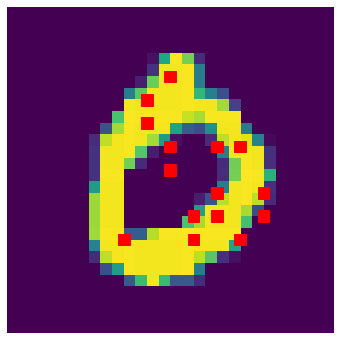

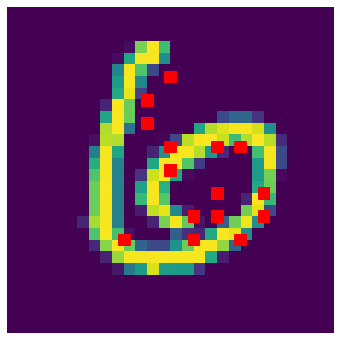

In [40]:


import matplotlib.patches as patches

fig, axes = plt.subplots(figsize=(6,6))

############## Diagnoal Gaussian Shift ############## 
axes.imshow(Feature_digit_0_Te[0].reshape([28,28]), cmap=plt.get_cmap('viridis'))

#axes.imshow(Feature_digit_6_Te[0].reshape([28,28]), cmap=plt.get_cmap('viridis'))
for i in range(d_proj):

    axes.add_patch(
        patches.Rectangle(
            xy=(idx_mat[i][0]*2+1, idx_mat[i][1]*2+1),  # point of origin.
            width=1, height=1, linewidth=1,
            color='red', fill=True))
plt.axis('off')
plt.savefig("detection_digit_0.pdf",bbox_inches='tight')





fig, axes = plt.subplots(figsize=(6,6))

############## Diagnoal Gaussian Shift ############## 
axes.imshow(Feature_digit_6_Te[0].reshape([28,28]), cmap=plt.get_cmap('viridis'))

#axes.imshow(Feature_digit_6_Te[0].reshape([28,28]), cmap=plt.get_cmap('viridis'))
for i in range(d_proj):

    axes.add_patch(
        patches.Rectangle(
            xy=(idx_mat[i][0]*2+1, idx_mat[i][1]*2+1),  # point of origin.
            width=1, height=1, linewidth=1,
            color='red', fill=True))
plt.axis('off')
plt.savefig("detection_digit_6.pdf",bbox_inches='tight')





In [42]:
p_val, decision =  Gaussian_MMD.GMMD_testing_revision(Feature_digit_0_Te_small_conv, Feature_digit_6_Te_small_conv, z_Gaussian_MMD1, sigma)
print('pval: ', p_val, '\t Decision: ',decision)



# print(1 - p_val)

pval:  0.009999999776482582 	 Decision:  1


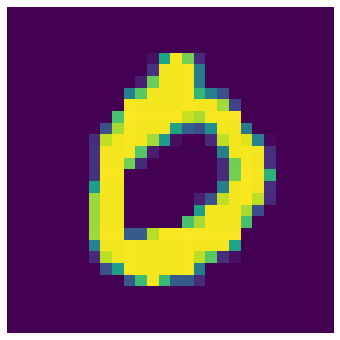

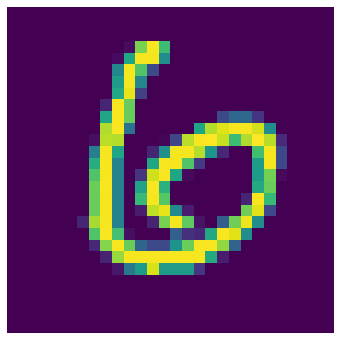

In [30]:

fig, axes = plt.subplots(figsize=(6,6))

############## Diagnoal Gaussian Shift ############## 
axes.imshow(Feature_digit_0_Te[0].reshape([28,28]), cmap=plt.get_cmap('viridis'))
plt.axis('off')


plt.savefig("digit0_origin.pdf",bbox_inches='tight')


fig, axes = plt.subplots(figsize=(6,6))

############## Diagnoal Gaussian Shift ############## 
axes.imshow(Feature_digit_6_Te[0].reshape([28,28]), cmap=plt.get_cmap('viridis'))
plt.axis('off')

plt.savefig("digit6_origin.pdf",bbox_inches='tight')
